In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import  precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


# Conf. display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('Stori_Data_Challenge (6).csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, 1 to 8950
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   activated_date                    8937 non-null   object 
 2   last_payment_date                 8941 non-null   object 
 3   balance                           8948 non-null   float64
 4   balance_frequency                 8950 non-null   float64
 5   purchases                         8950 non-null   float64
 6   oneoff_purchases                  8950 non-null   float64
 7   installments_purchases            8950 non-null   float64
 8   cash_advance                      8838 non-null   float64
 9   purchases_frequency               8950 non-null   float64
 10  oneoff_purchases_frequency        8950 non-null   float64
 11  purchases_installments_frequency  8950 non-null   float64
 12  cash_advanc

In [2]:
df.head()

,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud
1,C10001,2019-10-06,2020-09-09,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
2,C10002,2019-10-06,2020-07-04,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
3,C10003,2019-10-06,2020-09-17,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
4,C10004,2019-10-06,2020-08-24,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,0
5,C10005,2019-10-06,2020-10-20,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


### Question 1

1.1 Plot an histogram of the balance amount for all the customers.

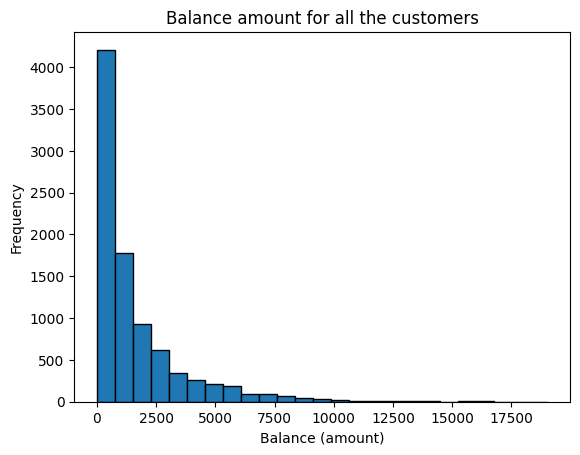

In [3]:
plt.hist(df['balance'], bins=25, edgecolor='black')
plt.title('Balance amount for all the customers')
plt.xlabel('Balance (amount)')
plt.ylabel('Frequency')

plt.show()

1.3 Report mean and median balance, grouped by year and month of activated_date.

In [4]:
#Transform into date type
df['activated_date'] = pd.to_datetime(df['activated_date'], errors='coerce')
df['last_payment_date'] = pd.to_datetime(df['last_payment_date'], errors='coerce')

In [5]:
# activated_date (in formatYYYY-MM)
df['year_month'] = df['activated_date'].dt.to_period('M')

# grouped by year and month of activated_date.
df.groupby('year_month')['balance'].agg(['mean', 'median'])


,mean,median
year_month,,
2019-10,2482.234166,1524.409377
2019-11,1848.704323,1082.071173
2019-12,2018.788906,1162.588384
2020-01,1854.535889,1175.749847
2020-02,1747.350977,994.841733
2020-03,1554.973023,828.954823
2020-04,1483.183191,910.141912
2020-05,1214.333732,734.557681
2020-06,939.997996,472.791862


In [6]:
# Save it in excel
Q1_3 = df.groupby('year_month')['balance'].agg(['mean', 'median'])

Q1_3.to_excel('Q1.3.xlsx')

### Question 2

2.1 Report in a table the following information for customers who activated their account and
made their last payment during 2020: cust_id (excluding letters), activated_date (in format
YYYY-MM), last_payment_date (in format YYYY-MM-DD), cash_advance, credit_limit, and a
calculated field of cash_advance as a percentage of credit_limit.

In [7]:
#Filter date 2020
df2020 = df[
    (df['activated_date'].dt.year == 2020) &
    (df['last_payment_date'].dt.year == 2020)
].copy()

#Remove the letters from the cust_id column
df2020['cust_id'] = df2020['cust_id'].str.extract('(\d+)', expand=False)

#activated_date (in formatYYYY-MM)
df2020['activated_date'] = df2020['activated_date'].dt.to_period('M').astype(str)
#last_payment_date (in format YYYY-MM-DD)
df2020['last_payment_date'] = df2020['last_payment_date'].dt.strftime('%Y-%m-%d')

# Calculate percentage
df2020['cash_advance_per'] = (df2020['cash_advance'] / df2020['credit_limit']) * 100

#Target columns
df2020 = df2020.loc[:,['cust_id','activated_date','last_payment_date','cash_advance','credit_limit','cash_advance_per']]

In [8]:
print(df2020.to_string(index=False))

cust_id activated_date last_payment_date  cash_advance  credit_limit  cash_advance_per
  12709        2020-01        2020-05-08   2431.292076   8000.000000         30.391151
  12710        2020-01        2020-05-26      0.000000   2000.000000          0.000000
  12712        2020-01        2020-10-20      0.000000   3000.000000          0.000000
  12713        2020-01        2020-08-22      0.000000   9000.000000          0.000000
  12714        2020-01        2020-04-26     78.763096   1500.000000          5.250873
  12715        2020-01        2020-10-16      0.000000   4000.000000          0.000000
  12716        2020-01        2020-05-06   2260.735690   9000.000000         25.119285
  12717        2020-01        2020-08-13    611.974158   3500.000000         17.484976
  12718        2020-01        2020-08-28      0.000000   9000.000000          0.000000
  12719        2020-01        2020-07-15   4200.991254   9000.000000         46.677681
  12720        2020-01        2020-05-06   

In [9]:
# To Excel
df2020.to_excel('df2020.xlsx')

## Question 3

3.1 Build a predictive model for fraud.



In [10]:
# Understanding the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, 1 to 8950
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   cust_id                           8950 non-null   object        
 1   activated_date                    8937 non-null   datetime64[ns]
 2   last_payment_date                 8941 non-null   datetime64[ns]
 3   balance                           8948 non-null   float64       
 4   balance_frequency                 8950 non-null   float64       
 5   purchases                         8950 non-null   float64       
 6   oneoff_purchases                  8950 non-null   float64       
 7   installments_purchases            8950 non-null   float64       
 8   cash_advance                      8838 non-null   float64       
 9   purchases_frequency               8950 non-null   float64       
 10  oneoff_purchases_frequency        8950 non-null   flo

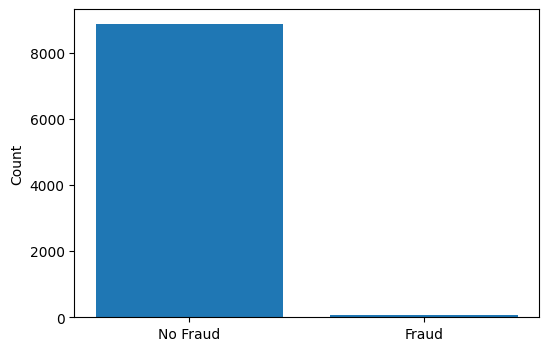

fraud
0    8880
1      70
Name: count, dtype: int64


In [11]:
# Let's see that we are dealing with an imbalanced dataset.

# Count the number of fraud and non-fraud cases
fraud_count = df['fraud'].value_counts()

# Bar char
plt.figure(figsize=(6, 4))
plt.bar(fraud_count.index, fraud_count.values)
plt.ylabel('Count')
plt.xticks([0, 1], ['No Fraud', 'Fraud'])
plt.show()

print(fraud_count)

Let's see that there are only 70 rows out of the 8950 entries.

In [12]:
fraud_count = df.dropna()['fraud'].value_counts()
fraud_count

,count
fraud,
0,8429
1,68


We see that if we drop the rows that contain null values in any of their columns, we lose 2 that are frauds. Since they are so few, we will look at these cases specifically to decide what to do with them and not lose them.

In [13]:
# Check the nans rows
fraud_nans = df[(df['fraud'] == 1) & df.isnull().any(axis=1)]
fraud_nans

,cust_id,activated_date,last_payment_date,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud,year_month
646,C10671,2019-10-26,2020-11-02,1482.235539,1.0,14604.87,2475.93,12128.94,NaN,1.000000,0.583333,1.0,0.0,0,219,15500.0,14462.630560,340.717801,1.0,12,1,2019-10
7425,C17626,2020-06-10,2020-10-16,1439.410201,1.0,184.70,184.70,0.00,NaN,0.166667,0.166667,0.0,0.0,0,2,1500.0,299.988581,4792.613550,0.0,12,1,2020-06


We observe that the entry with NaNs is in the cash_advance column, but if we look at the cash_advance_frequency, it is 0. Therefore, we will impute with 0 in those columns if their cash_advance_frequency is zero, and we will apply this same treatment to the entire dataset.

In [14]:
# Inserting 0s
df.loc[(df['cash_advance'].isnull()) & (df['cash_advance_frequency'] == 0), 'cash_advance'] = 0
df = df.dropna()
fraud_count = df['fraud'].value_counts()
fraud_count

,count
fraud,
0,8481
1,70


We obtain our 70 frauds again, since the non-frauds are many more, we will let go of the ones we removed by dropping NaNs. Now we will extract new features from the dates and other columns.

In [15]:
#We extract the dates into columns from the dates

df['activated_day'] = df['activated_date'].dt.day
df['activated_month'] = df['activated_date'].dt.month
df['activated_year'] = df['activated_date'].dt.year

df['last_payment_day'] = df['last_payment_date'].dt.day
df['last_payment_month'] = df['last_payment_date'].dt.month
df['last_payment_year'] = df['last_payment_date'].dt.year


# Now we create some new features, such as the days since activation, the days since the last payment, and the days between activation and payment
df['days_since_activation'] = (pd.to_datetime('today') - df['activated_date']).dt.days
df['days_since_last_payment'] = (pd.to_datetime('today') - df['last_payment_date']).dt.days
df['days_between_activation_and_payment'] = (df['last_payment_date'] - df['activated_date']).dt.days

# Using Question 2 idea
df['cash_advance_per'] = (df['cash_advance'] / df['credit_limit']) * 100
df['purchases_to_limit_ratio'] = df['purchases'] / df['credit_limit'] * 100

<ipython-input-15-cab7ced7a296>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['activated_day'] = df['activated_date'].dt.day
<ipython-input-15-cab7ced7a296>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['activated_month'] = df['activated_date'].dt.month
<ipython-input-15-cab7ced7a296>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [16]:
# Delete fisrt 3 columns (cust_id,activated_date,last_payment_date) y Fraud
X = df.drop(df.columns[:3], axis=1)
X = X.drop(columns=['fraud','year_month'])
Y = df['fraud']

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8551 entries, 1 to 8950
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   balance                              8551 non-null   float64
 1   balance_frequency                    8551 non-null   float64
 2   purchases                            8551 non-null   float64
 3   oneoff_purchases                     8551 non-null   float64
 4   installments_purchases               8551 non-null   float64
 5   cash_advance                         8551 non-null   float64
 6   purchases_frequency                  8551 non-null   float64
 7   oneoff_purchases_frequency           8551 non-null   float64
 8   purchases_installments_frequency     8551 non-null   float64
 9   cash_advance_frequency               8551 non-null   float64
 10  cash_advance_trx                     8551 non-null   int64  
 11  purchases_trx                      

We will use this raw data as is for our model. We will try with logistic regression (From previous research)

In [18]:
# Making the split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

# Setting a base LR
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train, Y_train)
Y_pred_lg = lg.predict(X_test)
print(classification_report(Y_test, Y_pred_lg))

#Cheking the confusion matrix
CM = confusion_matrix(Y_test, Y_pred_lg)
print("Conf. Matrix")
print(CM)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1697
           1       0.92      0.79      0.85        14

    accuracy                           1.00      1711
   macro avg       0.96      0.89      0.92      1711
weighted avg       1.00      1.00      1.00      1711

Conf. Matrix
[[1696    1]
 [   3   11]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
#Lets tune the hyperparameters with randorm search and check the results for comparison
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# Lists to store
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Parameters for Random Search
log_reg_params = {
    "penalty": ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Obtaining the best params
rand_log_reg = RandomizedSearchCV(LogisticRegression(solver='liblinear'), log_reg_params, n_iter=4, random_state=42)
rand_log_reg.fit(original_Xtrain, original_ytrain)
best_est = rand_log_reg.best_estimator_
y_pred = best_est.predict(original_Xtest)

# metrics
accuracy_lst.append(best_est.score(original_Xtest, original_ytest))
precision_lst.append(precision_score(original_ytest, y_pred))
recall_lst.append(recall_score(original_ytest, y_pred))
f1_lst.append(f1_score(original_ytest, y_pred))
auc_lst.append(roc_auc_score(original_ytest, y_pred))

# Print metrics
print('---')
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---')
conf_matrix = confusion_matrix(original_ytest, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Length of X (train): 6840 | Length of y (train): 6840
Length of X (test): 1711 | Length of y (test): 1711
---

accuracy: 0.9964932787843367
precision: 0.9
recall: 0.6428571428571429
f1: 0.75
---
Confusion Matrix:
[[1696    1]
 [   5    9]]


In [36]:
# Get the coefs to check the most important feature
coefs = np.abs(best_est.coef_[0])

#DataFrame with the feature names
coef_df = pd.DataFrame({'Feature': original_Xtrain.columns,'Coef': coefs})
# Sort
coef_df = coef_df.sort_values(by='Coef', ascending=False)
coef_df.head(5)

,Feature,Coef
18,activated_month,0.057266
10,cash_advance_trx,0.050370
16,tenure,0.020437
17,activated_day,0.012986
11,purchases_trx,0.010655


It increase the error type 2

In [37]:
#Now we Normalize the data

scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X_normalized, Y, test_size=0.2, random_state=42, stratify=Y)

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))


accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []


log_reg_params = {
    "penalty": ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}


rand_log_reg = RandomizedSearchCV(LogisticRegression(solver='liblinear'), log_reg_params, n_iter=4, random_state=42)
rand_log_reg.fit(original_Xtrain, original_ytrain)
best_est = rand_log_reg.best_estimator_
y_pred = best_est.predict(original_Xtest)

accuracy_lst.append(best_est.score(original_Xtest, original_ytest))
precision_lst.append(precision_score(original_ytest, y_pred))
recall_lst.append(recall_score(original_ytest, y_pred))
f1_lst.append(f1_score(original_ytest, y_pred))
auc_lst.append(roc_auc_score(original_ytest, y_pred))

print('---' )
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---')

conf_matrix = confusion_matrix(original_ytest, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Length of X (train): 6840 | Length of y (train): 6840
Length of X (test): 1711 | Length of y (test): 1711


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---

accuracy: 0.9964932787843367
precision: 0.9
recall: 0.6428571428571429
f1: 0.75
---
Confusion Matrix:
[[1696    1]
 [   5    9]]


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [38]:
# Get the coefs to check the most important feature
coefs = np.abs(best_est.coef_[0])

#DataFrame with the feature names
coef_df = pd.DataFrame({'Feature': original_Xtrain.columns,'Coef': coefs})
# Sort
coef_df = coef_df.sort_values(by='Coef', ascending=False)
coef_df.head(5)

,Feature,Coef
0,balance,0.666406
2,purchases,0.433388
5,cash_advance,0.427050
3,oneoff_purchases,0.373465
1,balance_frequency,0.324638


The normalization did not modificate the metrics

Now we try to combat the misbalance with SMOTE

In [21]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X_normalized, Y, test_size=0.2, random_state=42, stratify=Y)
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))


accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []


log_reg_params = {
    "penalty": ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}


rand_log_reg = RandomizedSearchCV(LogisticRegression(solver='liblinear'), log_reg_params, n_iter=4, random_state=42)

# CWe add the SMOTE
pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
pipeline.fit(original_Xtrain, original_ytrain)
best_est = rand_log_reg.best_estimator_
y_pred = best_est.predict(original_Xtest)

accuracy_lst.append(best_est.score(original_Xtest, original_ytest))
precision_lst.append(precision_score(original_ytest, y_pred))
recall_lst.append(recall_score(original_ytest, y_pred))
f1_lst.append(f1_score(original_ytest, y_pred))
auc_lst.append(roc_auc_score(original_ytest, y_pred))


print('---')
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---')
conf_matrix = confusion_matrix(original_ytest, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Length of X (train): 6840 | Length of y (train): 6840
Length of X (test): 1711 | Length of y (test): 1711
---

accuracy: 0.9485680888369374
precision: 0.11458333333333333
recall: 0.7857142857142857
f1: 0.2
---
Confusion Matrix:
[[1612   85]
 [   3   11]]


Lets see that this do not worked. Lets try to reduce the dimention and see if it improves.

### Reducción de dimensionalidad

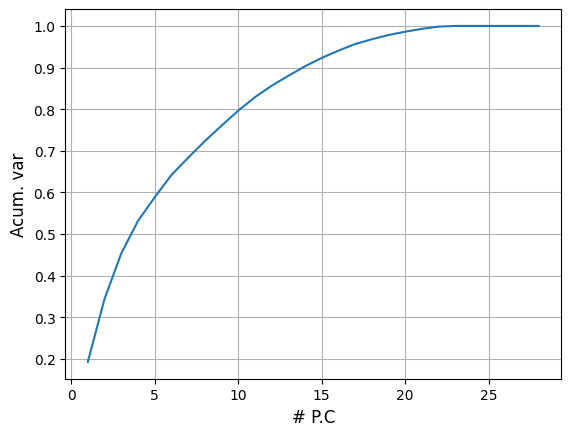

In [22]:
#Lets use PCA
pca = PCA()
pca.fit(X_normalized)

# Check the accumulate var
explained_variance = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum())
plt.xlabel('# P.C', fontsize=12)
plt.ylabel('Acum. var', fontsize=12)
plt.grid(True)
plt.show()

Lets use 14 principal components and see if the LG metrics change for good.

In [39]:
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X_normalized, Y, test_size=0.2, random_state=42, stratify=Y)

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# PCA w/ 14 components
pca = PCA(n_components=14)
X_train_pca = pca.fit_transform(original_Xtrain)
X_test_pca = pca.transform(original_Xtest)

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

log_reg_params = {
    "penalty": ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}


rand_log_reg = RandomizedSearchCV(LogisticRegression(solver='liblinear'), log_reg_params, n_iter=4, random_state=42)
rand_log_reg.fit(X_train_pca, original_ytrain)
best_est = rand_log_reg.best_estimator_
y_pred = best_est.predict(X_test_pca)


accuracy_lst.append(best_est.score(X_test_pca, original_ytest))
precision_lst.append(precision_score(original_ytest, y_pred))
recall_lst.append(recall_score(original_ytest, y_pred))
f1_lst.append(f1_score(original_ytest, y_pred))
auc_lst.append(roc_auc_score(original_ytest, y_pred))


print('---' )
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' )


conf_matrix = confusion_matrix(original_ytest, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Length of X (train): 6840 | Length of y (train): 6840
Length of X (test): 1711 | Length of y (test): 1711
---

accuracy: 0.9964932787843367
precision: 0.9
recall: 0.6428571428571429
f1: 0.75
---
Confusion Matrix:
[[1696    1]
 [   5    9]]


The metrics are the same lol.